In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import itertools

Загрузим данные

In [5]:
df = pd.read_csv('credit_card_default_analysis.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Задание 1

#### Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

Построим boxplot-ы для переменной LIMIT_BAL по значениям отклика default. Видим, что медианы значительно отличаются, для вернувших кредит (default = 0) медиана больше, первый и второй квартили расположены более симметрично относительно медианы, для невернувших (default = 1) - интерквартильный размах меньше, чем в предыдущем случае.

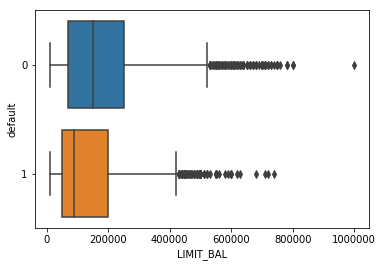

In [6]:
import seaborn as sns
sns.boxplot(y = 'default', x = 'LIMIT_BAL', data=df, orient = 'h')

И в том, и в другом случае распределения несимметричные с тяжелыми правыми хвостами.

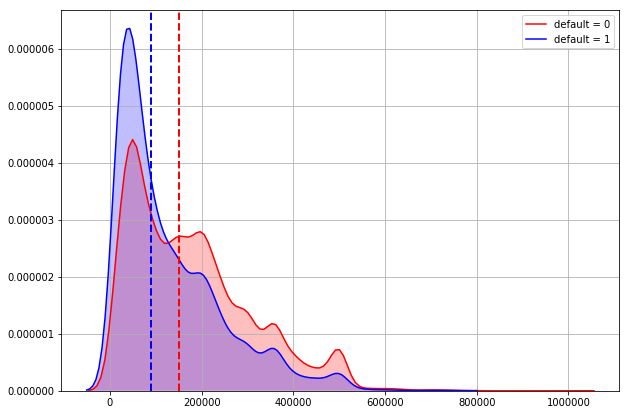

In [61]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
sns.kdeplot(df[df.default == 0]['LIMIT_BAL'], shade=True, color="r", label="default = 0")
sns.kdeplot(df[df.default == 1]['LIMIT_BAL'], shade=True, color="b", label="default = 1")
plt.axvline(np.median(df[df.default == 0]['LIMIT_BAL']), color='r', linestyle='dashed', linewidth=2)
plt.axvline(np.median(df[df.default == 1]['LIMIT_BAL']), color='b', linestyle='dashed', linewidth=2)
plt.grid()

а) Поскольку нам нужно проверить с помощью доверительного интервала гипотезу о равенстве медиан, то нужно использовать бутстреп. Это обосновывается тем, что критерий Стьюдента проверяет гипотезу о средних, а не о медианах, а также требует нормально распределенных данных, что очевидно не выполняется в нашем случае.

$H_0: med X_1 - med X_2 = 0$

$H_1: med X_1 - med X_2 \neq 0$

In [8]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [9]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

Рассчитаем векторы медиан по бустстрапированным выборкам:

In [10]:
limit_def_0_median_scores = list(map(np.median, get_bootstrap_samples(df[df.default == 0]['LIMIT_BAL'].values, 1000)))
limit_def_1_median_scores = list(map(np.median, get_bootstrap_samples(df[df.default == 1]['LIMIT_BAL'].values, 1000)))

Рассчитаем вектор разности между медианными значениями и доверительный интервал:

In [11]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(limit_def_1_median_scores, limit_def_0_median_scores)))

In [12]:
print ("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [60000. 70000.]


Поскольку интервал не содержит ноль, то гипотеза о равенстве медиан отвергается на уровне значимости 0.05.

In [55]:
print ("95% confidence interval for default = 0 medians",  stat_intervals(limit_def_0_median_scores, 0.05))
print ("95% confidence interval for default = 1 medians",  stat_intervals(limit_def_1_median_scores, 0.05))

95% confidence interval for default = 0 medians [150000. 150000.]
95% confidence interval for default = 1 medians [80000. 90000.]


б) Проверим гипотезу о равенстве распределений. Выборки у нас независимые. Подходит либо критерий Манна-Уинтни, либо перестановочный критерий. 
Для критерия Манна-Уитни должны выполняться условия: 1) В каждой из выборок должно быть не менее 3 значений признака. 2) В выборочных данных не должно быть совпадающих значений (все числа — разные) или таких совпадений должно быть очень мало (до 10). Проверим эти требования.

In [47]:
len(df[df.default == 0]['LIMIT_BAL'].values) >=3 and len(df[df.default == 1]['LIMIT_BAL'].values) >= 3

True

In [53]:
len(df[df.default == 0]['LIMIT_BAL'].value_counts()) == len(df[df.default == 0]['LIMIT_BAL'].values) and \
len(df[df.default == 1]['LIMIT_BAL'].value_counts()) == len(df[df.default == 1]['LIMIT_BAL'].values)

False

Очевидно, что требования не выполняются, потому используем перестановочный критерий, который не накладывает никаких ограничений. 

$ H_0: F_{X_1} (x) = F_{X_2}(x) $

$H_1: F_{X_1} (x) = F_{X_2} (x + \Delta ), \Delta \neq 0$

In [13]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [14]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [15]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), list(filter(lambda i: i not in index, range(n)))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [16]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [17]:
print ("p-value: %f" % permutation_test(df[df.default == 0]['LIMIT_BAL'].values, df[df.default == 1]['LIMIT_BAL'].values, max_permutations = 10000))

p-value: 0.000100


По 10000 перестановок p-value < 0.05, нулевая гипотеза об отсутствии сдвига между распределениями отвергается.

__Практическая значимость__: из доверительных интервалов, а также того, что гипотеза о равенстве распределений отвергнута, видно, что кредитные лимиты для клиентов без просрочек платежей выше. 

# Задание 2

#### Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

Посмотрим на количество мужчин (1) и женщин (2) в датасете

In [19]:
df['SEX'].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

Чтобы проверять гипотезу о равенстве долей (независимые выборки), перекодируем пол в бинарную переменную

In [20]:
df['SEX_binary'] = df['SEX'] - 1 # 0 = м, 1 = ж

In [21]:
print("Доля женщин среди вернувших кредит: %f" % np.mean(df[df.default == 0].SEX_binary))
print("Доля женщин среди НЕ вернувших кредит: %f" % np.mean(df[df.default == 1].SEX_binary))

Доля женщин среди вернувших кредит: 0.614150
Доля женщин среди НЕ вернувших кредит: 0.567058


Посмотрим также на распределения мужчин и женщин среди вернувших и не вернувших кредиты.

In [79]:
df_sex_def = pd.crosstab(df.default, df.SEX)
df_sex_def.columns = ['men', 'women']
df_sex_def

,men,women
default,,
0,9015,14349
1,2873,3763


Доли:

In [80]:
df_sex_def.T/np.sum(df_sex_def.T)

default,0,1
men,0.38585,0.432942
women,0.61415,0.567058


Покажем это на графике:

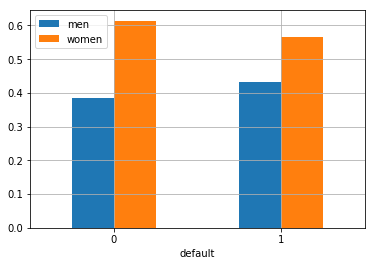

In [84]:
df_sex_def_part = df_sex_def.T/np.sum(df_sex_def.T)
df_sex_def_part.T.plot.bar(rot = 0)
plt.grid()

Доверительный интервал для разности двух долей (независимые выборки)

In [24]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [57]:
print ("confidence interval: [%f, %f]" % proportions_confint_diff_ind(df[df.default == 0]['SEX_binary'].values, df[df.default == 1]['SEX_binary'].values))

confidence interval: [0.033635, 0.060548]


Поскольку доверительный интервал не содержит 0, то гипотеза о равенстве долей отвергается на уровне значимости 0.05.

Z-критерий для доли для двух независимых выборок

$H_0 : p_1 = p_2$

$H_1 : p_1 \neq p_2$

In [26]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [27]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [28]:
print ("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(df[df.default == 0]['SEX_binary'].values, df[df.default == 1]['SEX_binary'].values)))

p-value: 0.000000


Поскольку p-value < 0.05, то гипотеза о равенстве долей отвергается.

__Практическая значимость:__ доля мужчин, возвращающих кредиты, меньше, чем доля женщин, возвращающих кредиты; т.е. мужчины реже возвращают кредиты. 

#  Задание 3

#### Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборот, не отдаст долг ?

Построим распределение заемщиков по образованию, в зависимости от возврата/невозврата долга

In [29]:
df_educ_def = pd.crosstab(df['EDUCATION'], df['default'])
df_educ_def.index = ['доктор', 'магистр', 'бакалавр', 'выпускник школы', 'начальное образование', 'прочее', 'нет данных']
df_educ_def

default,0,1
доктор,14,0
магистр,8549,2036
бакалавр,10700,3330
выпускник школы,3680,1237
начальное образование,116,7
прочее,262,18
нет данных,43,8


Представим на графике распределение людей по образованию, в зависимости от возврата/невозврата долга

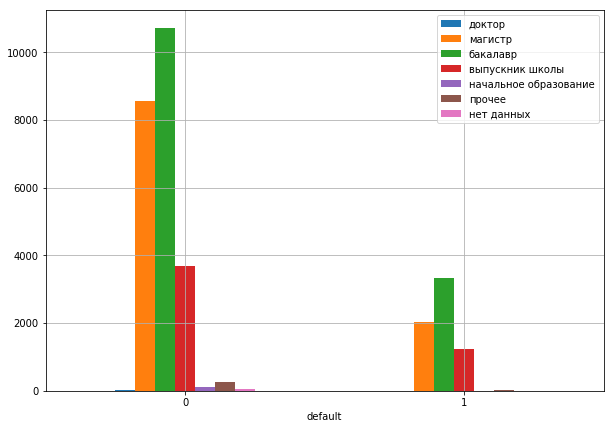

In [60]:
df_educ_def.T.plot.bar(rot = 0, figsize=(10, 7))
plt.grid()

Проверим условия применимости критерия хи-квадрат: 1) чтобы выборки были достаточно большими: n >= 40. 2) ожидаемое количество элементов в каждой ячейке таблицы было меньше 5 не более, чем в 20% ячеек.

In [31]:
(sum(sum(df_educ_def)) > 40, sum(sum(df_educ_def<5))/(df_educ_def.shape[0]*df_educ_def.shape[1])<0.2)

(True, True)

Поскольку условия выполняются, можем применять критерий.

$H_0: X_1 ~ и ~ X_2 ~ независимы$

$H_1: H_0 ~ неверна$

In [32]:
chi2_test = stats.chi2_contingency(df_educ_def)
chi2_test

(163.21655786997073,
 1.2332626245415605e-32,
 6,
 array([[1.0903200e+01, 3.0968000e+00],
        [8.2435980e+03, 2.3414020e+03],
        [1.0926564e+04, 3.1034360e+03],
        [3.8293596e+03, 1.0876404e+03],
        [9.5792400e+01, 2.7207600e+01],
        [2.1806400e+02, 6.1936000e+01],
        [3.9718800e+01, 1.1281200e+01]]))

Рассчитаем разность между наблюдаемым и ожидаемым количеством человек

In [33]:
diffs = df_educ_def - chi2_test[3]
diffs

default,0,1
доктор,3.0968,-3.0968
магистр,305.4020,-305.4020
бакалавр,-226.5640,226.5640
выпускник школы,-149.3596,149.3596
начальное образование,20.2076,-20.2076
прочее,43.9360,-43.9360
нет данных,3.2812,-3.2812


Самый простой способ получить значения одного масштаба для последующего сравнения - вычесть среднее и разделить на стандартное отклонение.

In [34]:
diffs_norm = (diffs - np.mean(diffs))/np.std(diffs)
diffs_norm

default,0,1
доктор,0.019915,-0.019915
магистр,1.963958,-1.963958
бакалавр,-1.456972,1.456972
выпускник школы,-0.960491,0.960491
начальное образование,0.129950,-0.129950
прочее,0.282541,-0.282541
нет данных,0.021101,-0.021101


Покажем разности на графике

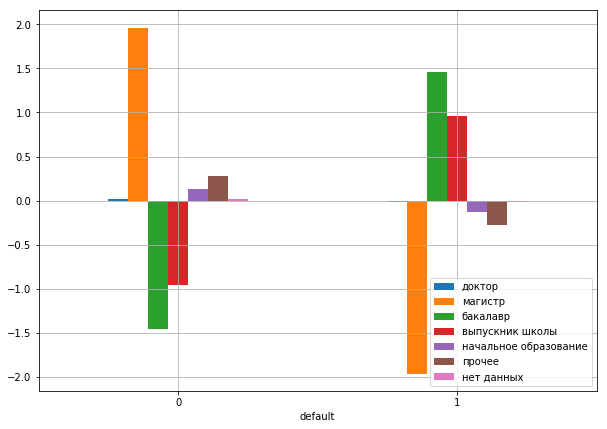

In [35]:
diffs_norm.T.plot.bar(figsize = (10,7), rot = 0)
plt.grid()

Если смотреть по разностям между реальными и ожидаемыми значениями, то кредиты чаще возвращают магистры и люди со статусом "прочее", а не возвращают - бакалавры и выпускники школ.

In [36]:
df_educ_def[0]/df_educ_def.sum(axis = 1)

доктор                   1.000000
магистр                  0.807652
бакалавр                 0.762651
выпускник школы          0.748424
начальное образование    0.943089
прочее                   0.935714
нет данных               0.843137
dtype: float64

Если же смотреть только на фактические значения, то доли возвращающих кредиты выше среди категорий "доктора" и людей с нач. образованием

__Практическая значимость:__ скорее всего отдаст долг человек с образованием "магистр", а не отдаст - "бакалавр".

# Задание 4

#### Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [37]:
df_mar_def = pd.crosstab(df.MARRIAGE, df.default)
df_mar_def.index = ['отказываюсь отвечать','замужем/женат', 'холост', 'нет данных']
df_mar_def

default,0,1
отказываюсь отвечать,49,5
замужем/женат,10453,3206
холост,12623,3341
нет данных,239,84


Покажем это распределение графически

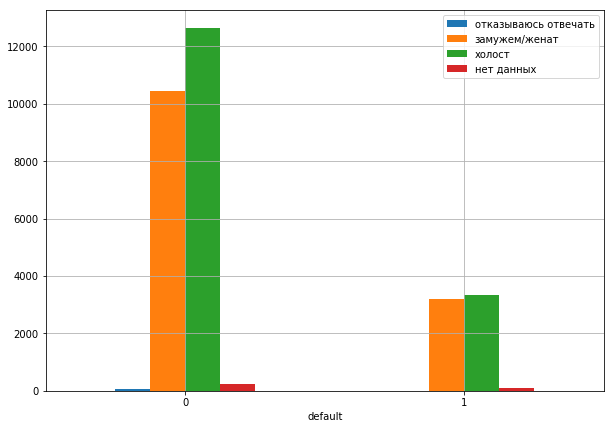

In [38]:
df_mar_def.T.plot.bar(rot = 0, figsize=(10, 7))
plt.grid()

Проверка условий применимости критерия хи-квадрат

In [39]:
(sum(sum(df_mar_def)) > 40, sum(sum(df_mar_def<5))/(df_mar_def.shape[0]*df_mar_def.shape[1])<0.2)

(True, True)

Применим критерий хи-квадрат:

$H_0: X_1 ~ и ~ X_2 ~ независимы$

$H_1: H_0 ~ неверна$

In [105]:
chi2_for_vcramer, pval, _, __ = stats.chi2_contingency(df_mar_def)

Мера, по которой можно измерить возможную связь категориальных переменных - это коэффициент корреляции V Крамера

In [106]:
K1 = df_mar_def.shape[0]
K2 = df_mar_def.shape[1]
n = sum(sum(df_mar_def))
v_cramer = np.sqrt(chi2_for_vcramer/(n*(min(K1, K2) - 1)))
print ('Cramer\'s V = %.4f' % v_cramer)
print ('p-value = ', pval)

Cramer's V = 0.0345
p-value =  8.825862457577375e-08


Коэффицент V Крамера имеет довольно маленькое значение, т.е. корреляция между признаками не очень значительна. Для категориальных признаков критерий хи-квадрат проверяет гипотезу о равенстве нулю коэффициента V Крамера против альтернативы, что он нулю не равен. p-value < 0.05, а значит нулевая гипотеза о независимости default и marriage и равенстве нулю коэффициента V Крамера отвергается. 

__Практическая значимость:__ семейное положение слабо влияет на то, вернет ли человек долг.

# Задание 5

#### Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

Графически видно, что распределения по возрасту вернувших и не вернувших кредит довольно похожи, а медианы почти совпадают

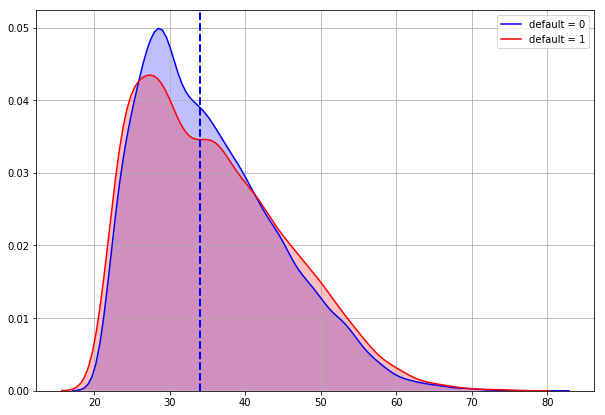

In [111]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
sns.kdeplot(df[df.default == 0]['AGE'], shade=True, color="blue", label="default = 0")
sns.kdeplot(df[df.default == 1]['AGE'], shade=True, color="red", label="default = 1")
plt.axvline(np.median(df[df.default == 0]['AGE']), color='r', linestyle='dashed', linewidth=2)
plt.axvline(np.median(df[df.default == 1]['AGE']), color='b', linestyle='dashed', linewidth=2)
plt.grid()

а) Поскольку нам нужно проверить с помощью доверительного интервала гипотезу о равенстве медиан, то нужно использовать бутстрап, как и в первом задании.

$H_0: med X_1 - med X_2 = 0$

$H_1: med X_1 - med X_2 \neq 0$

In [108]:
age_def_0_median_scores = list(map(np.median, get_bootstrap_samples(df[df.default == 0]['AGE'].values, 1000)))
age_def_1_median_scores = list(map(np.median, get_bootstrap_samples(df[df.default == 1]['AGE'].values, 1000)))

In [109]:
age_median_scores = list(map(lambda x: x[1] - x[0], zip(age_def_1_median_scores, age_def_0_median_scores)))

In [110]:
print ("95% confidence interval for default = 0 age medians",  stat_intervals(age_def_0_median_scores, 0.05))
print ("95% confidence interval for default = 1 age medians",  stat_intervals(age_def_1_median_scores, 0.05))

95% confidence interval for default = 0 age medians [34. 34.]
95% confidence interval for default = 1 age medians [34. 35.]


In [112]:
print ("95% confidence interval for the difference between medians",  stat_intervals(age_median_scores, 0.05))

95% confidence interval for the difference between medians [-1.  0.]


Доверительный интервал содержит 0, а значит, нет оснований отвергнуть нулевую гипотезу. Проверим теперь с помощью непараметрического критерия гипотезу о равенстве распределений. 

Условия критерия Манна-Уитни не выполняются, поэтому придется снова использовать перестановочный критерий.

In [113]:
len(df[df.default == 0]['AGE'].value_counts()) == len(df[df.default == 0]['AGE'].values) and \
len(df[df.default == 1]['AGE'].value_counts()) == len(df[df.default == 1]['AGE'].values)

False

In [115]:
len(df[df.default == 0]['AGE'].values) >=3 and len(df[df.default == 1]['AGE'].values) >= 3

True

In [116]:
stats.mannwhitneyu(df[df.default == 0]['AGE'].values, df[df.default == 1]['AGE'].values)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

In [118]:
df_age_0 = df[df.default == 0]['AGE'].values
df_age_1 = df[df.default == 1]['AGE'].values

Перестановочный критерий с разным числом перестановок:

In [119]:
print ("p-value: %f" % permutation_test(df_age_0, df_age_1, max_permutations = 5000))

p-value: 0.019400


In [120]:
print ("p-value: %f" % permutation_test(df_age_0, df_age_1, max_permutations = 10000))

p-value: 0.014200


In [121]:
print ("p-value: %f" % permutation_test(df_age_0, df_age_1, max_permutations = 15000))

p-value: 0.015400


Перестановочный критерий отвергает нулевую гипотезу о равенстве распределений

__Практическая значимость:__ 